# Working with Data

### Exploring Data

Simplest case is one-dimmensional data: a good start are summary statistics and a histogram

In [1]:
# Awful hack to import past chapter modules
import sys
sys.path.insert(0, "../")

from typing import List, Dict, NamedTuple, Tuple
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import math, random
from probability import inverse_normal_cdf
import numpy as np
import scipy
from stats import correlation, standard_deviation, variance
from linalg import Matrix, Vector, make_matrix, vector_mean, subtract, dot, magnitude, scalar_multiply
from gradient_descent import gradient_step
import datetime, csv
from collections import namedtuple
from dataclasses import dataclass
import tqdm

In [2]:
def _bucketize(point: float, bucket_size: float) -> float:
    """
    For a given data point, floor it to the appropriate bucket
    """
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
    return Counter([_bucketize(point, bucket_size) for point in points])

def plot_histogram(histogram_data: Dict[float, int], title: str = 'Histogram') -> None:
    xs = list(histogram_data.keys())
    xs.sort()
    ys = [histogram_data[k] for k in xs]
    width = xs[1] - xs[0] if len(xs) > 1 else 10
    plt.bar(xs, ys, width=width)
    plt.title(title)
    plt.show()

In [3]:
uniform_data = [200 * random.random() - 100 for _ in range(10000)]
normal_data = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]

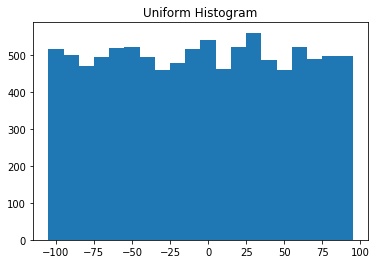

In [4]:
plot_histogram(make_histogram(uniform_data, 10), "Uniform Histogram")

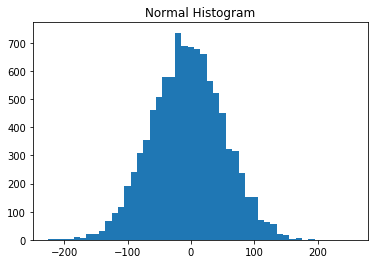

In [5]:
plot_histogram(make_histogram(normal_data, 10), "Normal Histogram")

In [6]:
def summary_stats(points: List[float]) -> Dict[str, float]:
    stats = {}
    stats['mean'] = np.mean(points)
    stats['stddev'] = np.std(points)
    stats['min'] = min(points)
    stats['max'] = max(points)
    return stats

In [7]:
print(summary_stats(uniform_data))
print(summary_stats(normal_data))

{'mean': -0.03587666001352429, 'stddev': 57.63279786105717, 'min': -99.99658219501899, 'max': 99.98987721822726}
{'mean': -0.29590001226961615, 'stddev': 56.77601013959761, 'min': -212.4955328553915, 'max': 251.82428754866123}


The point of the above exercise is to demonstrate how different data can be while having nearly the same mean and standard deviation. While the min and max in summary statistics provide slightly more insight, outliers can be constructed to mask this, such that we still can't really tell what's going on without a histogram. For example, see what happens when we add the adversarial outliers to form nearly the same summary statistics:

In [8]:
uniform_data += [-239, 234]
print(summary_stats(uniform_data))

{'mean': -0.03636938613629703, 'stddev': 57.72400403041316, 'min': -239, 'max': 234}


### Exploring Two-Dimmensional Data


In [9]:
def random_normal(mu:float = 0, sigma: float = 1) -> float:
    """
    random sample X from a normal distribution X ~ Normal(mu, sigma)
    """
    return inverse_normal_cdf(random.random(), mu, sigma)

In [10]:
xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

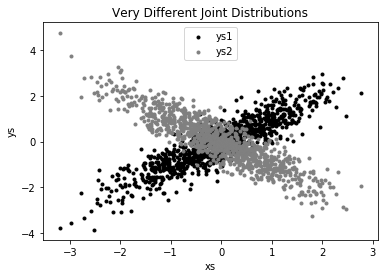

In [11]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='grey', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title('Very Different Joint Distributions')
plt.show()

In [12]:
print(correlation(xs, ys1), correlation(xs, ys2))

0.8860066477982925 -0.8946365027594835


In [13]:
def correlation_matrix(data: List[Vector]) -> Matrix:
    """
    Returns the len(data) * len(data)) correlation matrix whose (i, j)-th entry is 
    the correlation between data[i] and data[j]
    
    Note: in this example, the data is shaped (features * examples) vs. (examples * features): we provide 
    correlation across axis=0
    """
    def correlation_ij(i: int, j: int) -> float:
        # inner function which will serve as our data-generator for make_matrix 
        # (note: the function defines relationship to argument data)
        return correlation(data[i], data[j])
    return make_matrix(len(data), len(data), correlation_ij)

In [14]:
data = [i * np.random.random(100) for i in range(0, 4)]

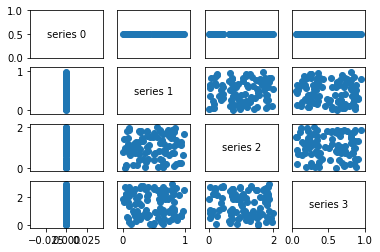

In [15]:
def scatter_matrix(data: List[Vector]) -> None:
    """
    For data of shape M * N, produce an M * M set of subplot scatter-plots where  the the plot at i, j is the
    scatter plot of data[i] against data[j]
    """
    num_features = len(data)
    
    # define sub-plots
    fig, ax = plt.subplots(num_features, num_features)
    
    # add data to them
    for i in range(num_features):
        for j in range(num_features):
            if i != j:
                ax[i][j].scatter(data[j], data[i]) # why j x i vs. i x j?
            else:
                ax[i][j].annotate("series " + str(i), (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
            if j > 0: 
                ax[i][j].yaxis.set_visible(False)
            if i < num_features - 1: 
                ax[i][j].xaxis.set_visible(False)
    plt.show()

scatter_matrix(data)

The above data is un-interesting b/c I didn't construct it in an interesting way. Actual data might prove more interesting. 

Show some stuff on NamedTuples and DataClasses here

### Working with Data: Using NamedTuples and DataClasses

Some convenient tricks shown to better handle data ingestion in data science pipelines

In [16]:
# stock prices as a dict: helpful for addressing features by name
stock_price = {'closing_price': 102.06, 'date': datetime.date(2015, 1, 2), 'symbol': 'BK'}
# but prone to spelling errors e.g. 
# stock_price['clossing_price'] = 1234.12

Beyond this, dicts have no support for non-uniform typing (e.g. we can do `Dict[str, int]` or `Dict[str, Any]` but not `Dict[str, 'closing_price' -> float, 'date -> datetime']`

In [17]:
# using a `namedtuple` gets us most of the way there
StockPrice = namedtuple('StockPrice', ['symbol', 'date', 'closing_price']) # this is like a typedef
price = StockPrice('BK', datetime.date(2016, 3, 3), 100.10)
assert price.symbol == 'BK'

In [18]:
# This solves spelling and field-hints, but doesn't solve the non-uniform type case. We can do one better by sub-classing
class StockPrice(NamedTuple):
    symbol: str
    date: datetime.date
    closing_price: float
    
    def pays_taxes(self) -> bool:
        # its a class so we can add methods too
        return False
    
price = StockPrice('AMZN', datetime.date(3000, 1, 1), 100000000.00)
assert price.symbol == 'AMZN'
assert not price.pays_taxes()

In [19]:
# Another way uses dataclasses

@dataclass
class StonkPrice:
    symbol: str
    date: datetime.date
    closing_price: float
    
    def pays_taxes(self) -> bool:
        # its a class so we can add methods too
        return False

price2 = StonkPrice('CVX', datetime.date(3000, 1, 1), 10.00)
assert price2.symbol == 'CVX'
assert not price2.pays_taxes()

# One key difference is they are mutable, which can be good but also bad
price2.cosing_price = 123412341234.00  # new field assignment b/c of course thats allowed
assert price2.closing_price == 10.

#### Cleaning Data

Skipping any code for the section on cleaning data (parsing and error handling of CSV strings -> NamedTuple. Would rather do this when getting to a real example

#### Manipulating Data

Also skipping this for the most part, but code here can answer the following questions:

- Given a list of `StockPrice` instances, return the maximum closing price for each stock symbol

**Will do:** What are the largest and smallest one-day percent changes?

In [20]:
# Start with some random data
def _semi_random_symbol() -> str:
    base = list('ABCD')
    random.shuffle(base)
    return ''.join(base[0:4])

def _random_stock():
    return StockPrice(_semi_random_symbol(), 
                      datetime.date(random.randint(2010, 2019), random.randint(1, 12), random.randint(1, 12)), 
                      np.random.normal(350, 100))
data = [_random_stock() for _ in range(100000)]

In [21]:
# first group prices by symbol: defaultdict lets us lazy assign keys that are not yet found via generator (empty list)
prices_by_symbol = defaultdict(list)
for sp in data:
    prices_by_symbol[sp.symbol].append(sp)

# specify a target class for our data
class DailyChange(NamedTuple):
    symbol: str
    date: datetime.date
    pct_change: float
        
def pct_change(start: float, end: float) -> float:
    return ((end - start) / start) * 100
    
# we can use a similar strategy to group daily changes
daily_changes_by_symbol = defaultdict(list)
for symbol in prices_by_symbol:
    sorted_by_date = prices_by_symbol[symbol]
    sorted_by_date.sort(key=lambda sp: sp.date)
    for i, current in enumerate(sorted_by_date[1:]):
        previous = sorted_by_date[i - 1]
        dc = DailyChange(symbol, current.date, pct_change(previous.closing_price, current.closing_price))
        daily_changes_by_symbol[symbol].append(dc)

# Now we can yield the results we actually wanted (we'll just print)
results: List[str] = []
for symbol in daily_changes_by_symbol:
    dcs: List[DailyChange] = daily_changes_by_symbol[symbol]
    min_change: float = min(dcs, key=lambda dc: dc.pct_change).pct_change
    max_change: float = max(dcs, key=lambda dc: dc.pct_change).pct_change
    results.append('Symbol: {0}, Max % Change: {1}, Min % Change {2}'.format(symbol, max_change, min_change))

# symbols are first unique element, so sort works to sort by symbol
results.sort()
for r in results:
    print(r)

# an aside: these vary so significantly b/c the data generator does not condition a new value on past at ALL

Symbol: ABCD, Max % Change: 12609.046815144195, Min % Change -99.12440930596891
Symbol: ABDC, Max % Change: 18398.80171256423, Min % Change -22231.152151005233
Symbol: ACBD, Max % Change: 8357.031327346163, Min % Change -3759.904762253602
Symbol: ACDB, Max % Change: 3079.0484754490008, Min % Change -4835.027775814817
Symbol: ADBC, Max % Change: 4073.0910790463313, Min % Change -8134.101259044327
Symbol: ADCB, Max % Change: 4272.626795709612, Min % Change -4575.167014472202
Symbol: BACD, Max % Change: 907.2160122781946, Min % Change -1168.9173657874062
Symbol: BADC, Max % Change: 1548.9112992024488, Min % Change -95.89924778691048
Symbol: BCAD, Max % Change: 20596.003718429194, Min % Change -99.66208643300851
Symbol: BCDA, Max % Change: 1503.5529593147724, Min % Change -94.55582392587951
Symbol: BDAC, Max % Change: 1687.881084963714, Min % Change -3564.9961253294427
Symbol: BDCA, Max % Change: 1090.6023844548588, Min % Change -9940.812640352286
Symbol: CABD, Max % Change: 1726.340210683

A more interesting question that can be answered like this is: "Which month was the best to invest in tech stocks?"
1. Remove non-tech symbols from the dataset
2. group changes by month
3. average the percent changes in a month
    - mathematical aside: why does this work? If % change is in part dictated by a previous value, why does this not fail on different permutations, etc?
4. return the month with the heighest average

### Rescaling

In some cases, analytical techniques are sensitive to scale. Imagine we we have the heights (inches) and weights (lbs) of all data scientists and we want to find clusters in the dataset. There is no comparison of an inch to a pound that is sensible, so we need to ensure our units don't mess up analyses.

In the clustering case, we want some notion of 'distance' between two data scientists across *both* these features. A general rule: *when feature units are not at all comparable, then best practice is to re-scale each feature to have a mean of zero and unit variance*

In [22]:
# data I copied from the internet:
h_and_w_csv = """
1,1.47,52.21
2,1.5,53.12
3,1.52,54.48
4,1.55,55.84
5,1.57,57.2
6,1.6,58.57
7,1.63,59.93
8,1.65,61.29
9,1.68,63.11
10,1.7,64.47
11,1.73,66.28
12,1.75,68.1
13,1.78,69.92
14,1.8,72.19
15,1.83,74.46
"""
class HeightAndWeight(NamedTuple):
    id: str
    height: float
    weight: float

def parse_row(row: List[str]) -> HeightAndWeight:
    # skipping the failure cases for time
    return HeightAndWeight(row[0], float(row[1]), float(row[2])) if len(row) == 3 else None

reader = csv.reader(h_and_w_csv.split('\n'))
data_scientists = [d for d in filter(lambda hw: hw is not None, [parse_row(r) for r in reader])]

In [23]:
# to start, we'll need to compute the mean and standard deviation for each feature (height, width)

def scale(data: List[Vector]) -> Tuple[Vector, Vector]:
    """
    Given a list of data points, return 
    1) a vector of their means across features and 
    2) a vector of their stddevs across features
    """
    assert data is not None and len(data) > 0
    num_features = len(data[0])
    means = vector_mean(data)
    # for each feature compute a standard deviation of the value at that features index for each vector
    # we could one-call this if we wrote a vector_stddev function
    stdevs = [standard_deviation([vector[i] for vector in data]) for i in range(num_features)]
    return means, stdevs

# test it
vectors = [[3, 3, 0], [1, 1, 0], [-1, 2, 0]]
means, stdevs = scale(vectors)
assert means == [1, 2, 0]
assert stdevs == [2, 1, 0]

In [24]:
def rescale(data: List[Vector]) -> List[Vector]:
    """
    rescale the input data so that each feature v[i] has mean = 0 and stdev = 1
    """
    assert data is not None and len(data) > 0
    num_features = len(data[0])
    means, stdevs = scale(data)
    
    # copy each vector prior to rescaling
    rescaled = [v[:] for v in data]
    for v in rescaled:
        for i in range(num_features):
            mu, sigma = means[i], stdevs[i]
            v[i] = (v[i] - mu) / sigma
    return rescaled
# this verifies against the real data we got from the csv
data = [[ds.weight, ds.height] for ds in data_scientists]
means, stdevs = scale(rescale(data))
assert all(np.isclose(means, [0, 0]))
assert all(np.isclose(stdevs, [1, 1]))
    

### Dimmensionality Reduction

Lets assume we have some high-dimmensional data, but there's some acix upon which most of the variance occurs (made up of some set of dimmensions). We'll use a technique **Principle Component Analysis** to find this set of dimmensions.


In [25]:
def recenter(data: List[Vector]) -> List[Vector]:
    """
    Like rescale, but we only center the data around a mean of 0 across all dimensions: there is no adjustment for variance
    """
    means = vector_mean(data)
    return [subtract(vector, means) for vector in data]

In [26]:
# setup some random data
xs = range(-50, 50)
ys1 = [4 * x + np.random.normal(200, 50) for x in xs]
ys2 = [-1 * x + np.random.normal(200, 20) for x in xs]
ys3 = [-15 * x + np.random.normal(200, 15) for x in xs]
data = list(zip(xs, ys1, ys2, ys3))

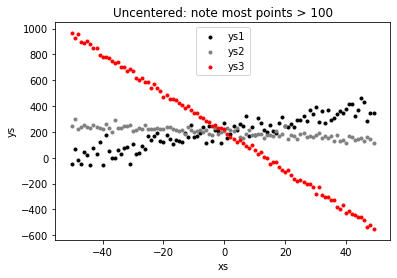

In [27]:
# plot it
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='grey', label='ys2')
plt.scatter(xs, ys3, marker='.', color='red', label='ys3')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title('Uncentered: note most points > 100')
plt.show()

In [28]:
rec_data = recenter(data)

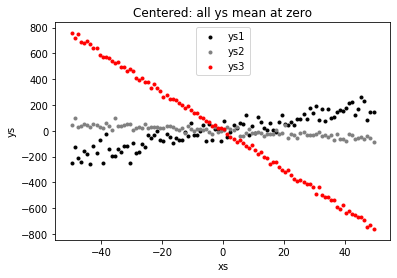

In [29]:
# plotting the centered data
plot_data = np.asarray(rec_data)
plt.scatter(plot_data[:, 0], plot_data[:, 1], marker='.', color='black', label='ys1')
plt.scatter(plot_data[:, 0], plot_data[:, 2], marker='.', color='grey', label='ys2')
plt.scatter(plot_data[:, 0], plot_data[:, 3], marker='.', color='red', label='ys3')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title('Centered: all ys mean at zero')
plt.show()

First, we want to be able to compute the direction of a vector:

In [30]:
# Setting up some basic pieces of PCA
def direction(v: Vector) -> Vector:
    """
    Return a vector whose magnitude is normalized to 1, indicating the primary direction of the vector
    """
    mag = magnitude(v)
    return [v_i / mag for v_i in v]

From here, we can determine the variance of our whole dataset in that direction. A key insight we'll depend on: **the `dot` product of two orthogonal vectors is zero**

The dot product of a with unit vector u, denoted a⋅u, is defined to be the projection of a in the direction of u, or the amount that a is pointing in the same direction as unit vector u

In [31]:
def directional_variance(data: List[Vector], w: Vector) -> float:
    """
    Given a dataset and a vector w from which to take a direction, return the variance in the data along that direction
    """
    dir_w = direction(w)
    # key insight: the dot product of two orthogonal vectors is zero. dot product against a magnitude vector is the portion 
    # of the magnitude of the query vector in THAT direction
    dot_projections: Vector = [dot(v, dir_w) for v in data]
    return variance(dot_projections)  # books code doesn't center mean but that should be ok, we already centered it

The point of PCA is to ***maximize this variance***, so we want to find the direction for which this is maximized. We can do this with gradient descent. First, lets compute the gradient of the directional variance of the dataset relative to some arbitrary direction

In [32]:
def dv_gradient(data: List[Vector], w: Vector) -> Vector:
    """
    Given a dataset and direction, compute the gradient of the directional variance relative to that direction
    """
    # if variance is sum of squares, do we just want to sum 2 * i in the dot projections?
    dir_w = direction(w)
    return [sum(2 * dot(v, dir_w) * v[i] for v in data)
            for i in range(len(w))]
    

In [33]:
def first_principal_component(data: List[Vector], epochs: int = 1000, step_size: float = .1) -> Vector:
    """
    Given a dataset, determine the first principle component using gradient descent
    epochs = # of epochs, step_size = learning rate
    """
    # start with a random guess
    dir_w = [np.random.uniform(-1, 1) for _ in data[0]]
    with tqdm.trange(epochs) as t:
        for _ in t:
            dv = directional_variance(data, dir_w)
            gradient = dv_gradient(data, dir_w)
            dir_w = gradient_step(dir_w, gradient, step_size)
            t.set_description(f"dv: {dv:.3f}")  # note the very nice formatting syntax for dv => 0.123
    return direction(dir_w)
    

In [34]:
# fingers crossed
pca_data = [
[20.9666776351559,-13.1138080189357],
[22.7719907680008,-19.8890894944696],
[25.6687103160153,-11.9956004517219],
[18.0019794950564,-18.1989191165133],
[21.3967402102156,-10.8893126308196],
[0.443696899177716,-19.7221132386308],
[29.9198322142127,-14.0958668502427],
[19.0805843080126,-13.7888747608312],
[16.4685063521314,-11.2612927034291],
[21.4597664701884,-12.4740034586705],
[3.87655283720532,-17.575162461771],
[34.5713920556787,-10.705185165378],
[13.3732115747722,-16.7270274494424],
[20.7281704141919,-8.81165591556553],
[24.839851437942,-12.1240962157419],
[20.3019544741252,-12.8725060780898],
[21.9021426929599,-17.3225432396452],
[23.2285885715486,-12.2676568419045],
[28.5749111681851,-13.2616470619453],
[29.2957424128701,-14.6299928678996],
[15.2495527798625,-18.4649714274207],
[26.5567257400476,-9.19794350561966],
[30.1934232346361,-12.6272709845971],
[36.8267446011057,-7.25409849336718],
[32.157416823084,-10.4729534347553],
[5.85964365291694,-22.6573731626132],
[25.7426190674693,-14.8055803854566],
[16.237602636139,-16.5920595763719],
[14.7408608850568,-20.0537715298403],
[6.85907008242544,-18.3965586884781],
[26.5918329233128,-8.92664811750842],
[-11.2216019958228,-27.0519081982856],
[8.93593745011035,-20.8261235122575],
[24.4481258671796,-18.0324012215159],
[2.82048515404903,-22.4208457598703],
[30.8803004755948,-11.455358009593],
[15.4586738236098,-11.1242825084309],
[28.5332537090494,-14.7898744423126],
[40.4830293441052,-2.41946428697183],
[15.7563759125684,-13.5771266003795],
[19.3635588851727,-20.6224770470434],
[13.4212840786467,-19.0238227375766],
[7.77570680426702,-16.6385739839089],
[21.4865983854408,-15.290799330002],
[12.6392705930724,-23.6433305964301],
[12.4746151388128,-17.9720169566614],
[23.4572410437998,-14.602080545086],
[13.6878189833565,-18.9687408182414],
[15.4077465943441,-14.5352487124086],
[20.3356581548895,-10.0883159703702],
[20.7093833689359,-12.6939091236766],
[11.1032293684441,-14.1383848928755],
[17.5048321498308,-9.2338593361801],
[16.3303688220188,-15.1054735529158],
[26.6929062710726,-13.306030567991],
[34.4985678099711,-9.86199941278607],
[39.1374291499406,-10.5621430853401],
[21.9088956482146,-9.95198845621849],
[22.2367457578087,-17.2200123442707],
[10.0032784145577,-19.3557700653426],
[14.045833906665,-15.871937521131],
[15.5640911917607,-18.3396956121887],
[24.4771926581586,-14.8715313479137],
[26.533415556629,-14.693883922494],
[12.8722580202544,-21.2750596021509],
[24.4768291376862,-15.9592080959207],
[18.2230748567433,-14.6541444069985],
[4.1902148367447,-20.6144032528762],
[12.4332594022086,-16.6079789231489],
[20.5483758651873,-18.8512560786321],
[17.8180560451358,-12.5451990696752],
[11.0071081078049,-20.3938092335862],
[8.30560561422449,-22.9503944138682],
[33.9857852657284,-4.8371294974382],
[17.4376502239652,-14.5095976075022],
[29.0379635148943,-14.8461553663227],
[29.1344666599319,-7.70862921632672],
[32.9730697624544,-15.5839178785654],
[13.4211493998212,-20.150199857584],
[11.380538260355,-12.8619410359766],
[28.672631499186,-8.51866271785711],
[16.4296061111902,-23.3326051279759],
[25.7168371582585,-13.8899296143829],
[13.3185154732595,-17.8959160024249],
[3.60832478605376,-25.4023343597712],
[39.5445949652652,-11.466377647931],
[25.1693484426101,-12.2752652925707],
[25.2884257196471,-7.06710309184533],
[6.77665715793125,-22.3947299635571],
[20.1844223778907,-16.0427471125407],
[25.5506805272535,-9.33856532270204],
[25.1495682602477,-7.17350567090738],
[15.6978431006492,-17.5979197162642],
[37.42780451491,-10.843637288504],
[22.974620174842,-10.6171162611686],
[34.6327117468934,-9.26182440487384],
[34.7042513789061,-6.9630753351114],
[15.6563953929008,-17.2196961218915],
[25.2049825789225,-14.1592086208169]
]
rec_pca_data = recenter(pca_data)
first_principal_component(rec_pca_data)

dv: 104.889: 100%|██████████| 1000/1000 [00:01<00:00, 878.02it/s]


[-0.9239501139454519, -0.38251298924374644]

In [35]:
# now to our data
first_principal_component(rec_data)

dv: 206582.797: 100%|██████████| 1000/1000 [00:01<00:00, 684.16it/s]


[0.06377278621708225,
 0.25355152831040556,
 -0.07310020129222558,
 -0.9624453308113682]

##### Why PCA?

Now that we have our first principal component, we can remove projections in that direction to transform our data from N dimmensions to N - 1

understanding the magnitudes making up a principal component are also in understanding which features are important, etc.

In [36]:
def project(v: Vector, w: Vector) -> Vector:
    """
    return the projection of v onto w
    """
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

In [37]:
def remove_projection_from_vector(v: Vector, w: Vector) -> Vector:
    """
    projects v onto w and subtracts that projection from v
    """
    return subtract(v, project(v, w))

In [38]:
def remove_projection(data: List[Vector], w: Vector) -> List[Vector]:
    """
    remove a direction from the dataset by removing it from each vector
    """
    return [remove_projection_from_vector(v, w) for v in data]

In [39]:
def project2(v: Vector, w: Vector) -> Vector:
    """return the projection of v onto the direction w"""
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

def remove_projection_from_vector2(v: Vector, w: Vector) -> Vector:
    """projects v onto w and subtracts the result from v"""
    return subtract(v, project2(v, w))

def remove_projection2(data: List[Vector], w: Vector) -> List[Vector]:
    return [remove_projection_from_vector2(v, w) for v in data]

In [40]:
first_pc = first_principal_component(rec_pca_data)
print(first_pc)
no_first_pc = remove_projection(pca_data, first_pc)

dv: 104.889: 100%|██████████| 1000/1000 [00:01<00:00, 912.89it/s]

[0.9238855821730595, 0.38266882686305526]


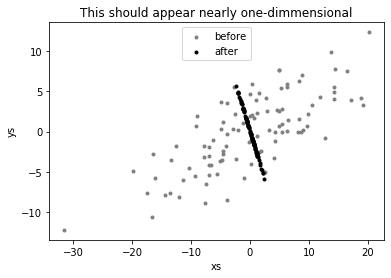

In [41]:
# python magic that seems to make intuitive sense to other people: extract each ys using zip
bys1, bys2 = zip(*rec_pca_data)
ys1, ys2 = zip(*recenter(no_first_pc))
plt.scatter(bys1, bys2, marker='.', color='grey', label='before')
plt.scatter(ys1, ys2, marker='.', color='black', label='after')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title('This should appear nearly one-dimmensional')
plt.show()

Look at that sick plot! removing the variance along PC1 yields one dimmensional data

In [42]:
def pca(data: List[Vector], num_components: int) -> List[Vector]:
    """
    Find a series of num_components principal components of data
    """
    data = recenter(data)  # to copy and make sure we don't forget
    components: List[Vector] = []
    for _ in range(num_components):
        component = first_principal_component(data)
        components.append(component)
        data = remove_projection(data, component)
    return components

# Notice how the two principal components are orthogonal: the dot product is zero. 
# This is b/c the data is only 2 dimmensional to begin with 
comp1, comp2 = pca(pca_data, 2)
print(comp1, comp2, dot(comp1, comp2))

dv: 8.378: 100%|██████████| 1000/1000 [00:01<00:00, 818.10it/s]

[-0.9239005646934066, -0.38263265223867676] [0.3826353622019645, -0.9238994423597037] -2.9331781332686546e-06


In [43]:
def transform_vector(v: Vector, span: List[Vector]) -> Vector:
    """
    transform the vector to live in the span of the components passed in
    """
    return [dot(v, w) for w in span]

def transform(data: List[Vector], span: List[Vector]) -> List[Vector]:
    return [transform_vector(v, span) for v in data]